In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt
import numpy as np
import flask

In [2]:

# Define the output channels
OUTPUT_CHANNELS = 3

# Rebuild the models using the same architecture
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')



# Load the weights from the .h5 file for each model
generator_g.load_weights('generate_after.h5')



# Initialize the optimizers with the same settings
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


# Optionally, compile the models if you plan to continue training
generator_g.compile(optimizer=generator_g_optimizer)


# Display model summaries to verify they are loaded correctly
# generator_g.summary()
# generator_f.summary()

In [3]:
def load_test_before():
    yield "test.jpg"

In [4]:
def load(image_path):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_path)
  image = tf.io.decode_image(image,channels=3)
  image = tf.ensure_shape(image, [None, None, 3])

  # Convert both images to float32 tensors
  image = tf.cast(image, tf.float32)

  return image

In [5]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [6]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [7]:
def process_image_paths(image_path):
    """Process combined paths using TensorFlow operations."""
    image = load(image_path)
    image = random_jitter(image)
    image = normalize(image)
    
    return image

In [8]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [9]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [10]:
output_signature = tf.TensorSpec(shape=(), dtype=tf.string)

test_before = tf.data.Dataset.from_generator(load_test_before, output_signature=output_signature)
test_before = test_before.map(process_image_paths).batch(BATCH_SIZE)


In [11]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

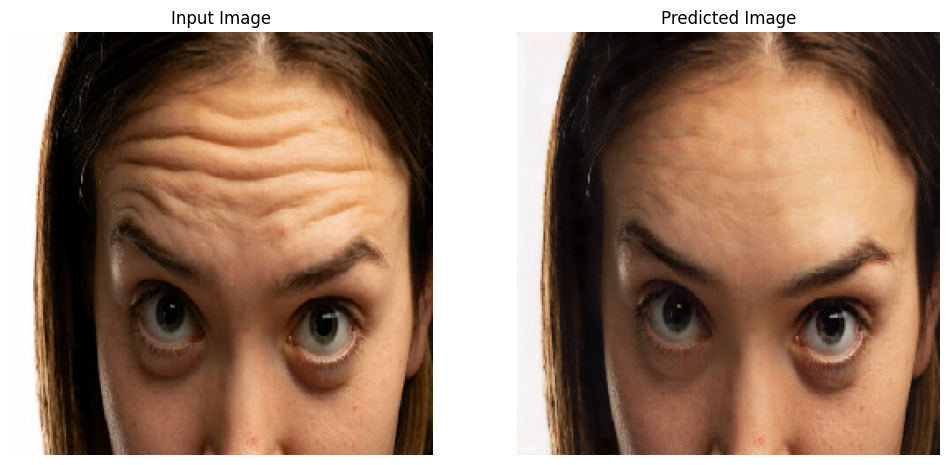

In [12]:
# Run the trained model on the test dataset
for inp in test_before.take(1):
      generate_images(generator_g, inp)
